In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43393")
client

<Client: 'tcp://127.0.0.1:43393' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
ddir = '/tank/groups/climode/tuchida/pyqg-runs/'

In [4]:
def _morlet(xo, ntheta, a, s, y, x, dim):
    r"""
    Define

    .. math::
        \psi = a e^{-2\pi i \boldmath{k}_0 \cdot\boldmath{x}} e^{-\frac{\boldmath{x} \cdot \boldmath{x}}{2 x_0^2}}

    as the morlet wavelet. Its transform is

    .. math::
        \psi_h = a 2\pi x_0^2 e^{-2 \pi^2 (\boldmath{k}-\boldmath{k}_0)^2 x_0^2}

    Units of :math:`a` are :math:`L^{-2}`.
    :math:`k_0` is defaulted to :math:`1/x_0` in the zonal direction.
    """
    ko = 1./xo

    # compute morlet wavelet
    th = np.arange(int(ntheta/2))*2.*np.pi/ntheta
    th = xr.DataArray(th, dims=['angle'], coords={'angle':th})

    # rotated positions
    yp = np.sin(th)*s**-1*y
    xp = np.cos(th)*s**-1*x

    arg1 = 2j*np.pi*ko*(yp-xp)
    arg2 = -(x**2+y**2)/2/s**2/xo**2
    m = a*np.exp(arg1)*np.exp(arg2)

    return m, th

In [12]:
L = 1000e3
rd = 100e3
N = 512
dx = L/N
xo = rd/dx
# ntheta = 36
ntheta = 8
ss = xr.DataArray(np.linspace(2*1.,xo,100)/xo, dims=['scale'], 
                  coords={'scale':np.linspace(2*1.,xo,100)/xo}
                 )

y = xr.DataArray(np.arange(N), dims=['y'], coords={'y':np.arange(N)}) - N/2 + dx/L/2
x = xr.DataArray(np.arange(N), dims=['x'], coords={'x':np.arange(N)}) - N/2 + dx/L/2
wavelet, th = _morlet(xo, ntheta, 1., ss, y, x, ['y','x'])
wavelet

<xarray.DataArray (angle: 4, scale: 100, y: 512, x: 512)>
array([[[[ 0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j, ...,
          -0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00+0.00000000e+00j],
         [ 0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j, ...,
          -0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00+0.00000000e+00j],
         [ 0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j, ...,
          -0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
          -0.00000000e+00+0.00000000e+00j],
         ...,
         [ 0.00000000e+00+0.00000000e+00j,
...
           1.85274121e-11+1.61492865e-12j],
         ...,
         [ 1.79581692e-11-4.78025373e-12j,
           2.01788127e-11-3.53409914e-12j,
           2.24899428e-11-1.95263881e-12j, ...,
           2.47939629e-11-1.83682899e-12j,
           2.25684222e-11+2.89488093e-13j,
           2.03805512e-11+2.03667251e-12j],
         [ 1.66176450e-11-2.91039944e-12j,
           1.85279722e-11-1.60864961e-12j,
           2.04937553e-11+3.47333362e-15j, ...,
           2.25684222e-11+2.89488093e-13j,
           2.03883272e-11+2.03744959e-12j,
           1.82721305e-11+3.44548353e-12j],
         [ 1.52523264e-11-1.32424901e-12j,
           1.68770065e-11+2.86035785e-15j,
           1.85274121e-11+1.61492865e-12j, ...,
           2.03805512e-11+2.03667251e-12j,
           1.82721305e-11+3.44548353e-12j,
           1.62482125e-11+4.55200344e-12j]]]])
Coordinates:
  * angle    (angle) float64 0.0 0.7854 1.571 2.356
  * scale    (scale) float64 0.03906 0.04877 0.05848 ... 0.9806 0.9903 1.0
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 503 504 505 506 507 508 509 510 511
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 503 504 505 506 507 508 509 510 511

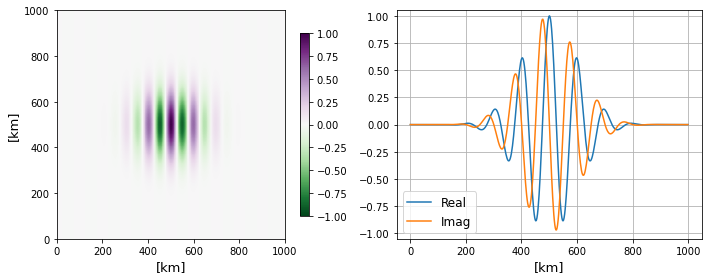

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)

im = ax1.pcolormesh((wavelet.x+.5)*dx*1e-3, (wavelet.y+.5)*dx*1e-3, 
                    wavelet.isel(angle=0,scale=-1).real, 
                    cmap='PRGn_r', vmax=1, vmin=-1, rasterized=True)
ax2.plot((wavelet.x+.5)*dx*1e-3, wavelet.isel(angle=0,scale=-1,y=N//2).real, label=r'Real')
ax2.plot((wavelet.x+.5)*dx*1e-3, wavelet.isel(angle=0,scale=-1,y=N//2).imag, label=r'Imag')
ax2.legend(loc='lower left', fontsize=12)
ax1.set_aspect(1)
ax2.set_ylim([-1.05,1.05])
ax2.grid(True)
fig.colorbar(im, ax=ax1, shrink=.8)
ax1.set_xlabel(r'[km]', fontsize=13)
ax1.set_ylabel(r'[km]', fontsize=13)
ax2.set_xlabel(r'[km]', fontsize=13)
plt.savefig(op.join(ddir,'Figs/Morlet_rd=%03dkm_N=%04d.pdf' % (100,N)))
# plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/NonDim-Morlet.pdf'))